In [1]:
# !git clone https://github.com/lukemelas/EfficientNet-PyTorch
# %cd EfficientNet-Pytorch
# !pip install -e
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=9b350b80b5c0b216b5cc1f7e83e2b6301290c5e2f35ab9f787a03366a474a329
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'  # b5

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=7)

224


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 95.3MB/s]


Loaded pretrained weights for efficientnet-b0


In [5]:
## 데이타 로드!!
batch_size  = 48
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = '/content/drive/MyDrive/Colab Notebooks/face_emotion/dataset'  # class 별 폴더로 나누어진걸 가져와서 라벨도 달아준다
emotion_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(emotion_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}

datasets['train'] = Subset(emotion_dataset, train_idx)  # date slice
tmp_dataset       = Subset(emotion_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 48,  tvt : 169 / 22 / 22


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
import os
total = 0
for i in os.listdir(data_path) :

  print(i+' : '+ str(len(os.listdir(data_path+'/'+i))))
  total += len(os.listdir(data_path+'/'+i))

print('total : {} / train : {} /valid : {} / test : {}'.format(total,len(datasets['train']),len(datasets['valid']),len(datasets['test'])))


surprise : 1553
sad : 1588
happy : 1572
angry : 1507
fear : 1121
disgust : 1248
neutral : 1527
total : 10116 / train : 8092 /valid : 1012 / test : 1012


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


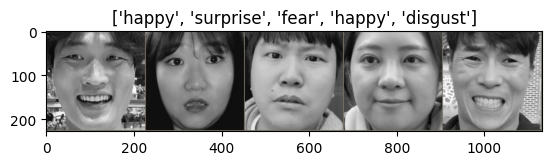

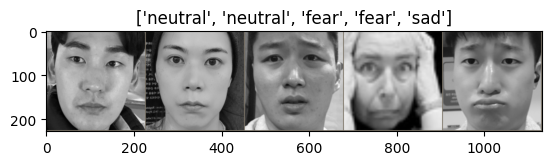

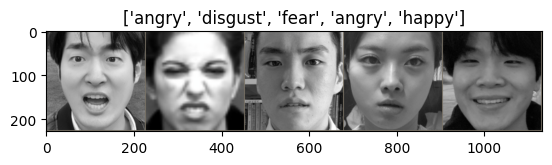

In [8]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    "0": "angry", 
    "1": "disgust",  
    "2": "fear",   
    "3": "happy", 
    "4": "neutral",   
    "5": "sad",   
    "6": "surprise"   
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'efficientNet_PER7.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.01, # 논문 학습률  : 0.001 
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.65 ** epoch
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [11]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.30 Acc: 50.5
valid Loss: 1.03 Acc: 61.7
==> best model saved - 0 / 61.7
Epoch 1/19
----------
train Loss: 0.74 Acc: 73.0
valid Loss: 0.76 Acc: 70.6
==> best model saved - 1 / 70.6
Epoch 2/19
----------
train Loss: 0.55 Acc: 80.5
valid Loss: 0.69 Acc: 75.1
==> best model saved - 2 / 75.1
Epoch 3/19
----------
train Loss: 0.48 Acc: 83.2
valid Loss: 0.67 Acc: 75.8
==> best model saved - 3 / 75.8
Epoch 4/19
----------
train Loss: 0.45 Acc: 84.5
valid Loss: 0.66 Acc: 75.8
Epoch 5/19
----------
train Loss: 0.45 Acc: 84.7
valid Loss: 0.66 Acc: 75.8
Epoch 6/19
----------
train Loss: 0.45 Acc: 84.4
valid Loss: 0.66 Acc: 75.6
Epoch 7/19
----------
train Loss: 0.44 Acc: 84.8
valid Loss: 0.66 Acc: 75.7
Epoch 8/19
----------
train Loss: 0.44 Acc: 84.8
valid Loss: 0.66 Acc: 75.6
Epoch 9/19
----------
train Loss: 0.45 Acc: 84.3
valid Loss: 0.66 Acc: 75.4
Epoch 10/19
----------
train Loss: 0.45 Acc: 83.8
valid Loss: 0.66 Acc: 75.7
Epoch 11/19
----------
train Loss: 

best model(validation) : epoch - 12 / acc- 76  / LOSS- 0.7


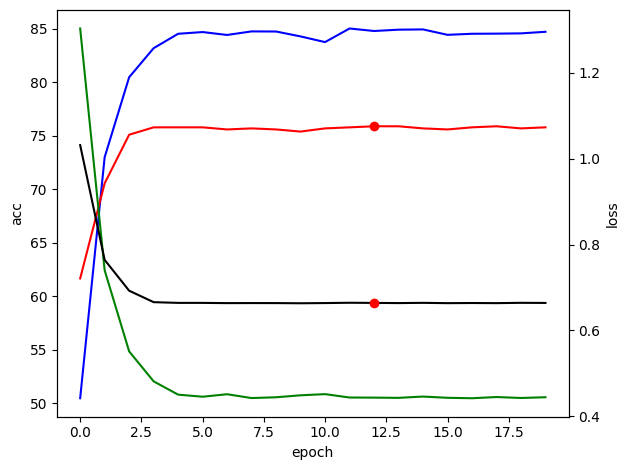

In [22]:
## 결과 그래프 그리기
print('best model(validation) : epoch - %d / acc- %1.f  / LOSS- %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [14]:
## 성능확인
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])          
            if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로
    
    ## TEST!
    # test_and_visualize_model(model, phase = 'test')

test done : loss/acc : 0.62 / 78.2


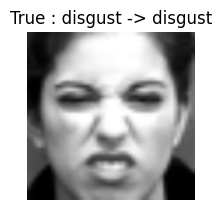

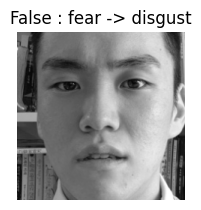

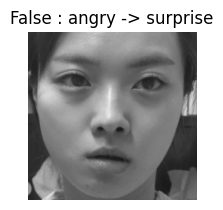

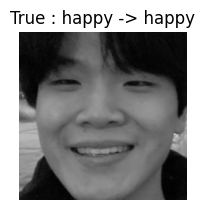

In [15]:
test_and_visualize_model(model, phase = 'test', num_images=4)

In [ ]:
image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=7)

224
Loaded pretrained weights for efficientnet-b0


In [ ]:
# 모델 불러오기
import cv2
import numpy as np
import torch

import matplotlib.pyplot as plt
import time
import os
import copy
import random

class_names = {
    "0": "angry", 
    "1": "disgust",  
    "2": "fear",   
    "3": "happy", 
    "4": "neutral",   
    "5": "sad",   
    "6": "surprise"   
}
seq_length = 30

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'  # b5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = EfficientNet.from_pretrained(model_name, num_classes=7)
model = model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/face_emotion/efficientNet_PER7.pt',map_location ='cpu'))
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
## 데이타 로드!!
batch_size  = 48
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = '/content/drive/MyDrive/Colab Notebooks/face_emotion/dataset'  # class 별 폴더로 나누어진걸 가져와서 라벨도 달아준다
emotion_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(emotion_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}

datasets['train'] = Subset(emotion_dataset, train_idx)  # date slice
tmp_dataset       = Subset(emotion_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 48,  tvt : 70 / 9 / 9


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
## 성능확인
import torch.nn as nn
import pandas as pd
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    df = pd.DataFrame(columns=['true','pred'])
    a=0
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size
            print('batch:'+ str(i))
            print('labels num : {} / output num : {}'.format(len(labels),len(outputs)))
            for j in range(len(labels)) :
              df.loc[a]=[class_names[str(labels[j].cpu().numpy())],class_names[str(preds[j].cpu().numpy())]]
              a+=1
    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    
    # 예시 그림 plot
    # with torch.no_grad():
    #     for i, (inputs, labels) in enumerate(dataloaders[phase]):
    #         inputs = inputs.to(device)
    #         labels = labels.to(device)

    #         outputs = model(inputs)
    #         _, preds = torch.max(outputs, 1)        
    #         
  
    #         # 예시 그림 plot
    #         for j in range(1, num_images+1):
    #             ax = plt.subplot(num_images//2, 2, j)
    #             ax.axis('off')
    #             ax.set_title('%s : %s -> %s'%(
    #                 'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
    #                 class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
    #             imshow(inputs.cpu().data[j])          
    #         if i == 0 : break

    return df
    ## TEST!
#     test_and_visualize_model(model, phase = 'test')

In [17]:
df = test_and_visualize_model(model, phase = 'test')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


batch:0
labels num : 48 / output num : 48
batch:1
labels num : 48 / output num : 48
batch:2
labels num : 48 / output num : 48
batch:3
labels num : 48 / output num : 48
batch:4
labels num : 48 / output num : 48
batch:5
labels num : 48 / output num : 48
batch:6
labels num : 48 / output num : 48
batch:7
labels num : 48 / output num : 48
batch:8
labels num : 48 / output num : 48
batch:9
labels num : 48 / output num : 48
batch:10
labels num : 48 / output num : 48
batch:11
labels num : 48 / output num : 48
batch:12
labels num : 48 / output num : 48
batch:13
labels num : 48 / output num : 48
batch:14
labels num : 48 / output num : 48
batch:15
labels num : 48 / output num : 48
batch:16
labels num : 48 / output num : 48
batch:17
labels num : 48 / output num : 48
batch:18
labels num : 48 / output num : 48
batch:19
labels num : 48 / output num : 48
batch:20
labels num : 48 / output num : 48
batch:21
labels num : 4 / output num : 4
test done : loss/acc : 0.62 / 78.2


<Figure size 640x480 with 0 Axes>

In [18]:
df['true']

0         angry
1       disgust
2          fear
3         angry
4         happy
         ...   
1007       fear
1008    disgust
1009      happy
1010    disgust
1011      happy
Name: true, Length: 1012, dtype: object

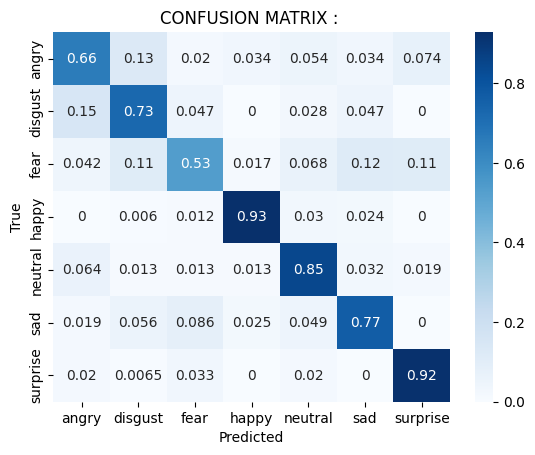

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
LABELS = ['angry','disgust','fear','happy','neutral','sad','surprise']
cm = confusion_matrix(df['true'], df['pred'], normalize='true')
sns.heatmap(cm,xticklabels=LABELS, yticklabels=LABELS, annot=True, cmap='Blues')
plt.title("CONFUSION MATRIX : ")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/face_emotion/result.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
heatmap_data = df[["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]]

KeyError: ignored